In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
drop_movies_without_synopsis = True
keep_us_movies_only = False

In [3]:
columns = ["WikiID", "FreebaseID", "Name", "ReleaseDate", "BoxOfficeRevenue", "Runtime", "Languages", "Countries", "Genres"]
df_meta = pd.read_csv("movie.metadata.tsv", sep="\t", names=columns)
df_meta.loc[df_meta["WikiID"]==29666067, "ReleaseDate"] = "2010-12-02"
df_meta["ReleaseDate"] = pd.to_datetime(df_meta["ReleaseDate"])
df_meta = df_meta[~df_meta["ReleaseDate"].isna()]

In [4]:
print("% of movies without revenue information:", df_meta["BoxOfficeRevenue"].isna().sum() / df_meta["BoxOfficeRevenue"].shape[0])

% of movies without revenue information: 0.8887211213404775


In [5]:
if drop_movies_without_synopsis:
    df_synopsis = pd.read_csv("plot_summaries.txt", sep="\t", names=["WikiID", "synopsis"])
    print("% of movies without synopsis:", df_synopsis.shape[0] / df_meta.shape[0])
    df_meta = df_meta[df_meta["WikiID"].isin(df_synopsis["WikiID"])]
df_meta["ReleasePeriod"] = pd.qcut(df_meta["ReleaseDate"].dt.year, 10)

% of movies without synopsis: 0.5652534106548724


In [6]:
def remove_fb_id(row):
    row = eval(row)
    new_row = []
    for id, cat in row.items():
        new_row.append(cat)
    return new_row

In [7]:
# df = df_meta.copy()
# df["genres"] = df["genres"].apply(remove_fb_id)
# df = df.explode("genres")

In [8]:
# df_synopsis = pd.read_csv("plot_summaries.txt", sep="\t", names=["IDwiki", "synopsis"])
# df_full = df_meta.merge(df_synopsis, on="IDwiki").sort_values("release")
# df_full.head(3)

In [9]:
# df_meta = df_full

In [10]:
countries = df_meta["Countries"].apply(remove_fb_id).explode()
df_countries = pd.merge(df_meta[["WikiID"]], countries, left_index=True, right_index=True)

genres = df_meta["Genres"].apply(remove_fb_id).explode()
df_genres = pd.merge(df_meta["WikiID"], genres, left_index=True, right_index=True)

languages = df_meta["Languages"].apply(remove_fb_id).explode()
df_languages = pd.merge(df_meta["WikiID"], languages, left_index=True, right_index=True)

In [11]:
usa_ids = df_countries[df_countries["Countries"] == "United States of America"]["WikiID"]
if keep_us_movies_only:
    df_meta = df_meta[df_meta["WikiID"].isin(usa_ids)]
    df_meta.loc[:, "ReleasePeriod"] = pd.qcut(df_meta["ReleaseDate"].dt.year, 10)

In [12]:
movie_counts_by_period = df_meta.groupby("ReleasePeriod")["WikiID"].count()
genre_list = df_genres["Genres"].value_counts()[0:5].index # Only plot the most popular genres
genre_dfs = {}
for g in genre_list:
    df_g = df_meta[["WikiID", "ReleasePeriod"]].merge(df_genres[df_genres["Genres"] == g], on="WikiID")
    genre_dfs[g] = df_g.groupby("ReleasePeriod")["WikiID"].count() / movie_counts_by_period

<AxesSubplot:xlabel='ReleasePeriod'>

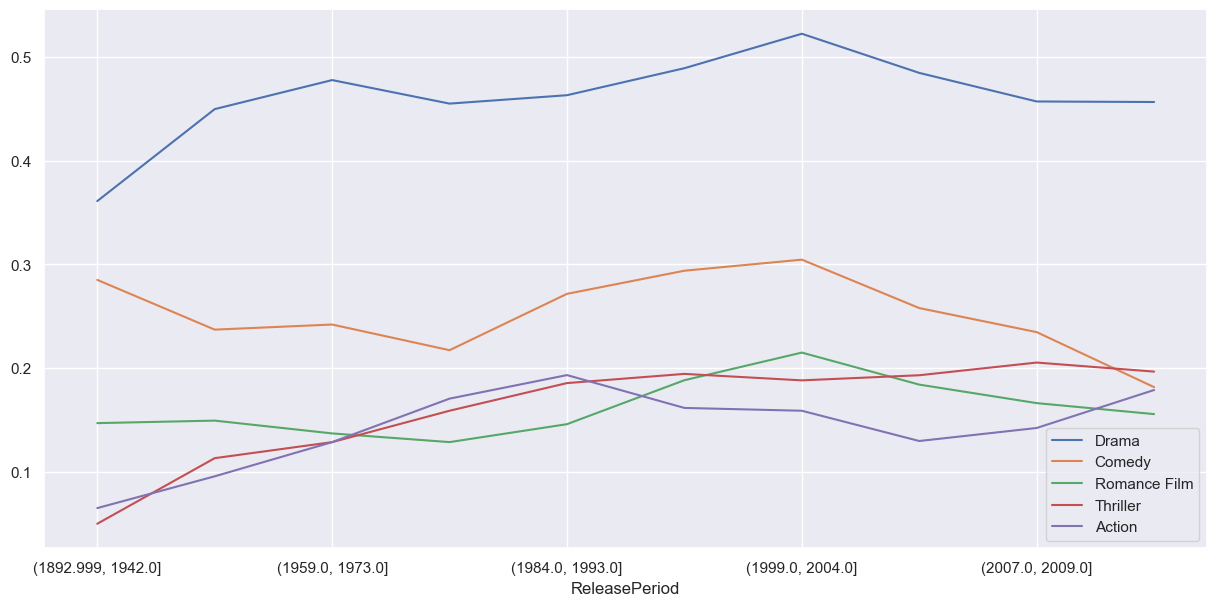

In [13]:
pd.concat(genre_dfs.values(), axis=1, keys=genre_list).plot.line(figsize=(15,7))

In [14]:
# ((df.release >= "1995-01-01") & (df.release < "2001-01-01")).sum()

In [15]:
# df_nonan = df[(~df.release.isna()) & (~df.revenue.isna()) & (~df.runtime.isna())]
# df_nonan = df_nonan.sort_values("release")
# df_usa = df_nonan[df_nonan["countries"] == '{"/m/09c7w0": "United States of America"}']